# Objective 3: Simulation Comparative Analysis

This notebook compares two different simulation results side by side, allowing for direct comparison of flow characteristics between different model types (e.g., Newtonian vs. Non-Newtonian) or different configurations.

## Import Required Libraries

In [33]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
import time
import sys
import math
from matplotlib.colors import LinearSegmentedColormap

# Add simulation_src to path to import utils
sys.path.append('../simulation_src')
from utils.load_csv import load_csv_data

## Define Simulation Paths

Here we define the paths to the two simulations we want to compare.

In [34]:
# Define the base directory where the simulation results are located
base_dir = Path.cwd()

# Define paths for the two simulations to compare
# Simulation 1: Standard BGK (Newtonian)
simulation1_folder = base_dir / '../results/pipe_flow/standard_zouhe_standard_bgk'
param_file1 = simulation1_folder / 'parameters' / 'pipe_zh_bgk_params.json'

# Simulation 2: Non-Newtonian BGK
simulation2_folder = base_dir / '../results/pipe_flow/standard_zouhe_non_newtonian_bgk'
param_file2 = simulation2_folder / 'parameters' / 'pipe_zh_nnbgk_params.json'

# Verify that both simulation folders exist
if not simulation1_folder.exists():
    print(f"Warning: Simulation 1 folder not found: {simulation1_folder}")
else:
    print(f"Found Simulation 1 folder: {simulation1_folder}")

if not simulation2_folder.exists():
    print(f"Warning: Simulation 2 folder not found: {simulation2_folder}")
else:
    print(f"Found Simulation 2 folder: {simulation2_folder}")

Found Simulation 1 folder: /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/pipe_flow/standard_zouhe_standard_bgk
Found Simulation 2 folder: /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/pipe_flow/standard_zouhe_non_newtonian_bgk


## Load Simulation Parameters

Load and compare the parameters from both simulation configurations.

In [35]:
# Function to load parameters from a JSON file
def load_parameters(param_file):
    """Load simulation parameters from a JSON file"""
    try:
        with open(param_file, 'r') as f:
            params = json.load(f)
        return params
    except Exception as e:
        print(f"Error loading parameters from {param_file}: {e}")
        return None

# Load parameters for both simulations
params1 = load_parameters(param_file1)
params2 = load_parameters(param_file2)

# Create a function to extract key parameters for comparison
def extract_key_parameters(params, label):
    """Extract key parameters from the JSON configuration"""
    if params is None:
        return {"Simulation": label, "Status": "Not available"}
    
    try:
        # Extract common parameters
        param_dict = {
            "Simulation": label,
            "Status": "Loaded",
            "FPS": params['input_parameters'].get('fps', "N/A"),
            "Time Step (dt)": params['input_parameters'].get('dt', "N/A"),
            "Spatial Resolution (dx)": params['input_parameters'].get('dx', "N/A"),
            "Vessel Length": f"{params['input_parameters'].get('vessel_length_mm', 'N/A')} mm",
            "Vessel Diameter": f"{params['input_parameters'].get('vessel_diameter_mm', 'N/A')} mm",
            "Kinematic Viscosity": params['input_parameters'].get('kinematic_viscosity', "N/A")
        }
        
        # Check for collision operator type to identify Newtonian vs. Non-Newtonian
        if 'numerical' in params and 'collision_operator' in params['numerical']:
            collision_type = params['numerical']['collision_operator'].get('type', "Unknown")
            param_dict["Collision Operator"] = collision_type
            
            # For non-Newtonian models, extract rheological parameters
            if "NonNewtonian" in collision_type and 'details' in params['numerical']['collision_operator']:
                details = params['numerical']['collision_operator']['details']
                param_dict["Rheology Model"] = "Carreau-Yasuda"
                param_dict["μ_0 (zero shear viscosity)"] = details.get('mu_0', "N/A")
                param_dict["μ_∞ (infinite shear viscosity)"] = details.get('mu_inf', "N/A")
                param_dict["λ (relaxation time)"] = details.get('lambda', "N/A")
                param_dict["n (power index)"] = details.get('n', "N/A")
                param_dict["a (transition parameter)"] = details.get('a', "N/A")
            else:
                param_dict["Rheology Model"] = "Newtonian"
        
        return param_dict
        
    except Exception as e:
        print(f"Error extracting parameters: {e}")
        return {"Simulation": label, "Status": "Error parsing parameters"}

# Extract key parameters from both simulations
sim1_params = extract_key_parameters(params1, "Simulation 1 (Standard BGK)")
sim2_params = extract_key_parameters(params2, "Simulation 2 (Non-Newtonian BGK)")

# Create a DataFrame to compare parameters side by side
# Get all unique parameter keys
all_keys = set(list(sim1_params.keys()) + list(sim2_params.keys()))
# Create comparison DataFrame
comparison_data = []
for key in all_keys:
    comparison_data.append({
        "Parameter": key,
        "Simulation 1": sim1_params.get(key, "N/A"),
        "Simulation 2": sim2_params.get(key, "N/A")
    })

# Convert to DataFrame and sort by parameter name (keeping Simulation and Status at the top)
comparison_df = pd.DataFrame(comparison_data)
# Custom sort order
priority_order = ["Simulation", "Status", "Rheology Model"]
# Sort the DataFrame
comparison_df["SortOrder"] = comparison_df["Parameter"].apply(lambda x: 
                                         priority_order.index(x) if x in priority_order else len(priority_order))
comparison_df = comparison_df.sort_values("SortOrder").drop("SortOrder", axis=1)

# Display parameters comparison
display(HTML("<h3>Simulation Parameters Comparison</h3>"))
display(HTML(comparison_df.to_html(index=False)))

# Store key simulation parameters for later use
# For simulation 1
dt1 = params1['input_parameters']['dt'] if params1 and 'input_parameters' in params1 else None
dx1 = params1['input_parameters']['dx'] if params1 and 'input_parameters' in params1 else None
fps1 = params1['input_parameters']['fps'] if params1 and 'input_parameters' in params1 else None

# For simulation 2
dt2 = params2['input_parameters']['dt'] if params2 and 'input_parameters' in params2 else None
dx2 = params2['input_parameters']['dx'] if params2 and 'input_parameters' in params2 else None
fps2 = params2['input_parameters']['fps'] if params2 and 'input_parameters' in params2 else None

# Verify parameter consistency for valid comparison
if dt1 != dt2 or dx1 != dx2:
    display(HTML("<div style='color:red; font-weight:bold;'>Warning: Simulations have different time steps or spatial resolutions!</div>"))
    display(HTML("<div style='color:red;'>This may affect direct comparison of results.</div>"))
else:
    display(HTML("<div style='color:green; font-weight:bold;'>✓ Simulations have matching time steps and spatial resolutions.</div>"))

Parameter,Simulation 1,Simulation 2
Simulation,Simulation 1 (Standard BGK),Simulation 2 (Non-Newtonian BGK)
Status,Loaded,Loaded
Rheology Model,Newtonian,Carreau-Yasuda
Vessel Length,15 mm,15 mm
Kinematic Viscosity,0.000003,0.000003
λ (relaxation time),N/A,3.313
μ_0 (zero shear viscosity),N/A,0.056
Vessel Diameter,6.5 mm,6.5 mm
FPS,100,100
Time Step (dt),0.00001,0.00001


## Load Velocity Data from Both Simulations

Now we'll load the velocity magnitude data for both simulations.

In [36]:
# Define paths to the processed data directories
data_dir1 = simulation1_folder / 'processed_data' / 'raw_fields'
data_dir2 = simulation2_folder / 'processed_data' / 'raw_fields'

# Function to load velocity data and frame mapping
def load_simulation_data(data_dir, label):
    """Load velocity magnitude data and frame mapping from a simulation directory"""
    result = {"label": label}
    
    try:
        # Check if directory exists
        if not data_dir.exists():
            print(f"Error: Data directory for {label} not found: {data_dir}")
            return result
        
        # Load frame mapping
        frame_mapping_path = data_dir / 'frame_mapping.npz'
        if not frame_mapping_path.exists():
            print(f"Error: Frame mapping for {label} not found: {frame_mapping_path}")
            return result
            
        frame_mapping = np.load(frame_mapping_path)
        result["frame_numbers"] = frame_mapping['frame_numbers']
        result["frame_indices"] = frame_mapping['frame_indices']
        
        # Load velocity magnitude data
        u_magnitude_path = data_dir / 'u_magnitude.npz'
        if not u_magnitude_path.exists():
            print(f"Error: Velocity magnitude data for {label} not found: {u_magnitude_path}")
            return result
            
        start_time = time.time()
        u_magnitude_data = np.load(u_magnitude_path)['data']
        load_time = time.time() - start_time
        
        # Crop off the top 5 pixels from the velocity magnitude data
        if u_magnitude_data.ndim == 3:  # [frames, height, width]
            u_magnitude_data = u_magnitude_data[:, :-5, :]  # Remove the top 5 rows from each frame
            print(f"Cropped top 5 pixels: New shape = {u_magnitude_data.shape}")
            
        result["u_magnitude"] = u_magnitude_data
        
        # Also load x and y velocity components if available
        u_x_path = data_dir / 'u_x.npz'
        u_y_path = data_dir / 'u_y.npz'
        if u_x_path.exists() and u_y_path.exists():
            u_x_data = np.load(u_x_path)['data']
            u_y_data = np.load(u_y_path)['data']
            
            # Crop off the top 5 pixels from velocity components
            if u_x_data.ndim == 3:  # [frames, height, width]
                u_x_data = u_x_data[:, :-5, :]  # Remove the top 5 rows from each frame
                u_y_data = u_y_data[:, :-5, :]  # Remove the top 5 rows from each frame
                print(f"Cropped top 5 pixels from velocity components")
                
            result["u_x"] = u_x_data
            result["u_y"] = u_y_data
        
        # Load wall mask if available
        wall_mask_path = data_dir / 'wall_mask.npz'
        if wall_mask_path.exists():
            wall_mask_data = np.load(wall_mask_path)['data']
            
            # Crop off the top 5 pixels from wall mask
            if wall_mask_data.ndim == 3:  # [frames, height, width]
                wall_mask_data = wall_mask_data[:, :-5, :]  # Remove the top 5 rows from each frame
                print(f"Cropped top 5 pixels from wall mask")
                
            result["wall_mask"] = wall_mask_data
        
        # Load dimensions
        dimensions_path = data_dir / 'dimensions.npz'
        if dimensions_path.exists():
            dimensions = np.load(dimensions_path)['data']
            # Adjust dimensions to reflect the cropping of the top 5 pixels
            if len(dimensions) >= 2:
                dimensions[1] = dimensions[1] - 5  # Reduce height by 5
                print(f"Adjusted dimensions after cropping: {dimensions}")
            result["dimensions"] = dimensions
            
        # Print summary of loaded data
        print(f"Loaded data for {label}:")
        print(f"  Frames: {len(result.get('frame_numbers', []))} frames from {min(result.get('frame_numbers', [0]))} to {max(result.get('frame_numbers', [0]))}")
        if 'u_magnitude' in result:
            print(f"  Velocity magnitude shape: {result['u_magnitude'].shape}")
            print(f"  Data loaded in {load_time:.2f} seconds")
            
            # Calculate basic statistics for first frame
            first_frame = result['u_magnitude'][0]
            print(f"  First frame statistics:")
            print(f"    Min: {first_frame.min():.6f}")
            print(f"    Max: {first_frame.max():.6f}")
            print(f"    Mean: {first_frame.mean():.6f}")
            print(f"    Std: {first_frame.std():.6f}")
        
        return result
        
    except Exception as e:
        print(f"Error loading data for {label}: {e}")
        return result

# Load data for both simulations
print("Loading simulation data...\n")
sim1_data = load_simulation_data(data_dir1, "Simulation 1 (Standard BGK)")
print("\n" + "-"*50 + "\n")
sim2_data = load_simulation_data(data_dir2, "Simulation 2 (Non-Newtonian BGK)")

# Check if data was loaded successfully
sim1_loaded = 'u_magnitude' in sim1_data and 'frame_numbers' in sim1_data
sim2_loaded = 'u_magnitude' in sim2_data and 'frame_numbers' in sim2_data

if sim1_loaded and sim2_loaded:
    print("\n✓ Successfully loaded data from both simulations")
    # Calculate physical time arrays
    sim1_data["physical_times"] = sim1_data["frame_numbers"] * dt1
    sim2_data["physical_times"] = sim2_data["frame_numbers"] * dt2
else:
    if not sim1_loaded:
        print("\n✗ Failed to load data for Simulation 1")
    if not sim2_loaded:
        print("\n✗ Failed to load data for Simulation 2")
    print("\nPlease check the file paths and ensure the simulations have been processed.")

Loading simulation data...

Cropped top 5 pixels: New shape = (101, 325, 751)
Cropped top 5 pixels: New shape = (101, 325, 751)
Cropped top 5 pixels from velocity components
Cropped top 5 pixels from wall mask
Adjusted dimensions after cropping: [752 326   1]
Loaded data for Simulation 1 (Standard BGK):
  Frames: 101 frames from 0 to 100000
  Velocity magnitude shape: (101, 325, 751)
  Data loaded in 0.44 seconds
  First frame statistics:
    Min: 0.000000
    Max: 0.512935
    Mean: 0.402115
    Std: 0.100934

--------------------------------------------------

Cropped top 5 pixels from velocity components
Cropped top 5 pixels from wall mask
Adjusted dimensions after cropping: [752 326   1]
Loaded data for Simulation 1 (Standard BGK):
  Frames: 101 frames from 0 to 100000
  Velocity magnitude shape: (101, 325, 751)
  Data loaded in 0.44 seconds
  First frame statistics:
    Min: 0.000000
    Max: 0.512935
    Mean: 0.402115
    Std: 0.100934

------------------------------------------

## Compare Velocity Magnitude Fields

Create side-by-side visualizations of the velocity magnitude fields from both simulations.


Comparing frame 100 out of 101:


/tmp/ipykernel_96520/3557461024.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


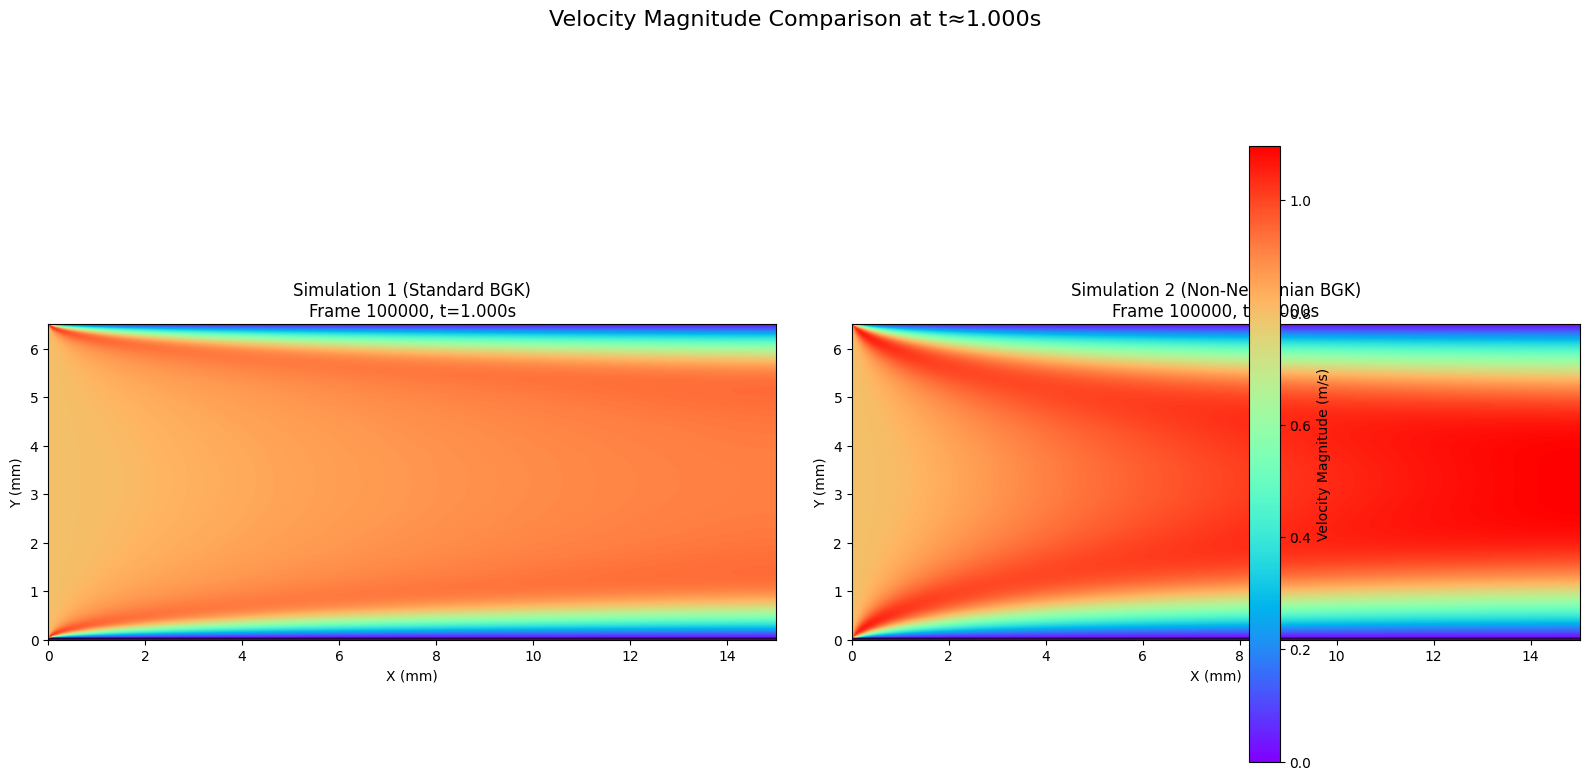

In [37]:
# Function to plot velocity fields from both simulations side by side
def compare_velocity_fields(sim1_data, sim2_data, frame_idx=0, use_physical_units=True):
    """Create a side-by-side comparison of velocity fields from two simulations"""
    if not 'u_magnitude' in sim1_data or not 'u_magnitude' in sim2_data:
        print("Error: Velocity data not available for comparison")
        return
    
    # Ensure the frame index is valid for both simulations
    if frame_idx >= len(sim1_data['u_magnitude']) or frame_idx >= len(sim2_data['u_magnitude']):
        print(f"Error: Frame index {frame_idx} out of bounds")
        return
    
    # Get the velocity field data for the specified frame
    vel_field1 = sim1_data['u_magnitude'][frame_idx]
    vel_field2 = sim2_data['u_magnitude'][frame_idx]
    
    # Get corresponding frame numbers and physical times
    frame_num1 = sim1_data['frame_numbers'][frame_idx]
    frame_num2 = sim2_data['frame_numbers'][frame_idx]
    time1 = sim1_data['physical_times'][frame_idx]
    time2 = sim2_data['physical_times'][frame_idx]
    
    # Set up the figure for comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Calculate physical dimensions for plotting
    ny1, nx1 = vel_field1.shape
    ny2, nx2 = vel_field2.shape
    
    # Create coordinate grids in physical units (mm)
    x1_mm = np.linspace(0, nx1 * dx1 * 1000, nx1)  # Convert m to mm
    y1_mm = np.linspace(0, ny1 * dx1 * 1000, ny1)  # Convert m to mm
    x2_mm = np.linspace(0, nx2 * dx2 * 1000, nx2)  # Convert m to mm
    y2_mm = np.linspace(0, ny2 * dx2 * 1000, ny2)  # Convert m to mm
    
    # Convert to physical velocity units if requested
    if use_physical_units:
        vel_scale1 = dx1 / dt1  # m/s per lattice unit
        vel_scale2 = dx2 / dt2  # m/s per lattice unit
        vel_field1_phys = vel_field1 * vel_scale1
        vel_field2_phys = vel_field2 * vel_scale2
        vel_unit = "m/s"
    else:
        vel_field1_phys = vel_field1
        vel_field2_phys = vel_field2
        vel_unit = "lattice units"
    
    # Determine common color scale for both plots
    vmin = min(vel_field1_phys.min(), vel_field2_phys.min())
    vmax = max(vel_field1_phys.max(), vel_field2_phys.max())
    
    # Create color maps
    cmap = 'rainbow'
    
    # Plot simulation 1
    im1 = ax1.imshow(vel_field1_phys, cmap=cmap, origin='lower',
                    vmin=vmin, vmax=vmax,
                    extent=[0, max(x1_mm), 0, max(y1_mm)])
    ax1.set_title(f"{sim1_data['label']}\nFrame {frame_num1}, t={time1:.3f}s")
    ax1.set_xlabel('X (mm)')
    ax1.set_ylabel('Y (mm)')
    
    # Add wall mask overlay for simulation 1 if available
    if 'wall_mask' in sim1_data:
        wall_mask1 = sim1_data['wall_mask'][frame_idx]
        ax1.contour(np.linspace(0, max(x1_mm), nx1), np.linspace(0, max(y1_mm), ny1),
                   wall_mask1, levels=[0.5], colors='black', linewidths=0.5)
    
    # Plot simulation 2
    im2 = ax2.imshow(vel_field2_phys, cmap=cmap, origin='lower',
                    vmin=vmin, vmax=vmax,
                    extent=[0, max(x2_mm), 0, max(y2_mm)])
    ax2.set_title(f"{sim2_data['label']}\nFrame {frame_num2}, t={time2:.3f}s")
    ax2.set_xlabel('X (mm)')
    ax2.set_ylabel('Y (mm)')
    
    # Add wall mask overlay for simulation 2 if available
    if 'wall_mask' in sim2_data:
        wall_mask2 = sim2_data['wall_mask'][frame_idx]
        ax2.contour(np.linspace(0, max(x2_mm), nx2), np.linspace(0, max(y2_mm), ny2),
                   wall_mask2, levels=[0.5], colors='black', linewidths=0.5)
    
    # Add colorbar
    cbar = fig.colorbar(im1, ax=[ax1, ax2], label=f'Velocity Magnitude ({vel_unit})')
    
    # Set the same aspect ratio for both plots
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.suptitle(f"Velocity Magnitude Comparison at t≈{time1:.3f}s", fontsize=16, y=1.05)
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # Return the fields for further analysis
    return vel_field1_phys, vel_field2_phys

# Compare velocity fields at a few time points if data is available
if sim1_loaded and sim2_loaded:
    # Find frames at specific time points (beginning, one-third, two-thirds, end)
    total_frames = min(len(sim1_data['u_magnitude']), len(sim2_data['u_magnitude']))
    # frames_to_compare = [0, total_frames//3, 2*total_frames//3, total_frames-1]
    frames_to_compare = [total_frames-1]
    
    for idx in frames_to_compare:
        print(f"\nComparing frame {idx} out of {total_frames}:")
        vel1, vel2 = compare_velocity_fields(sim1_data, sim2_data, frame_idx=idx, use_physical_units=True)

## Compare Mean and Maximum Velocity Over Time

Calculate and compare the mean and maximum velocity values over time for both simulations.

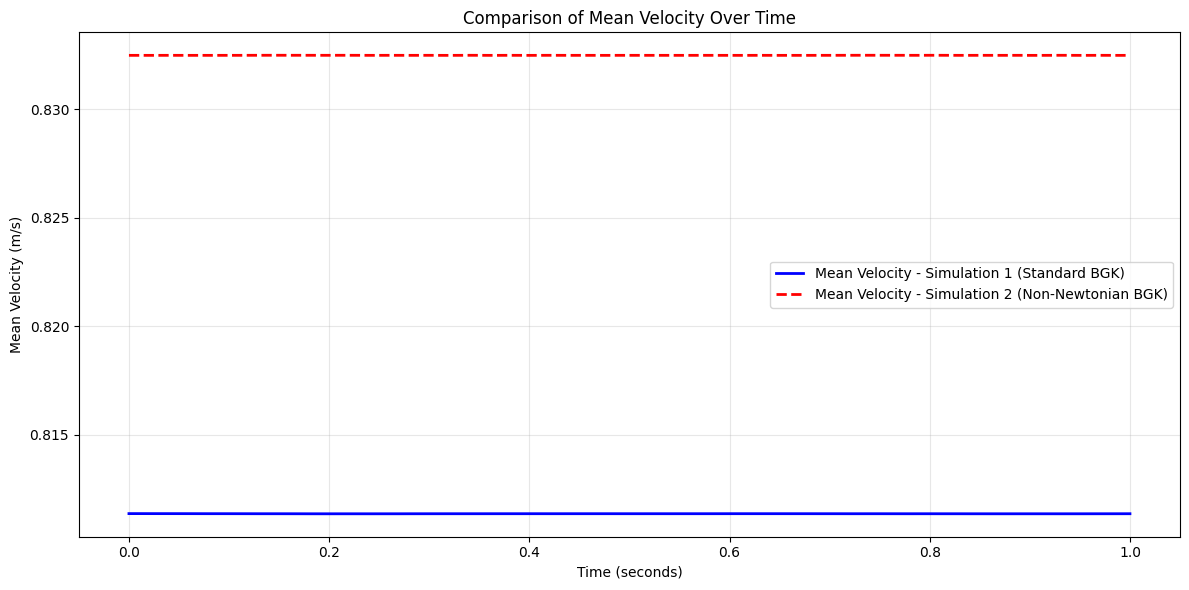

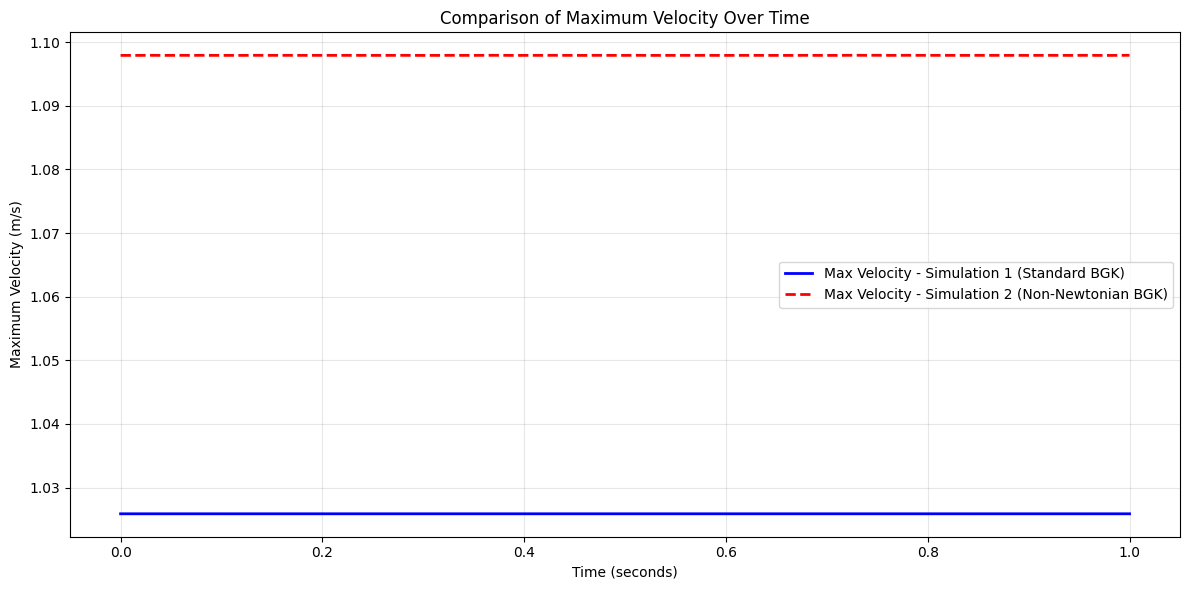

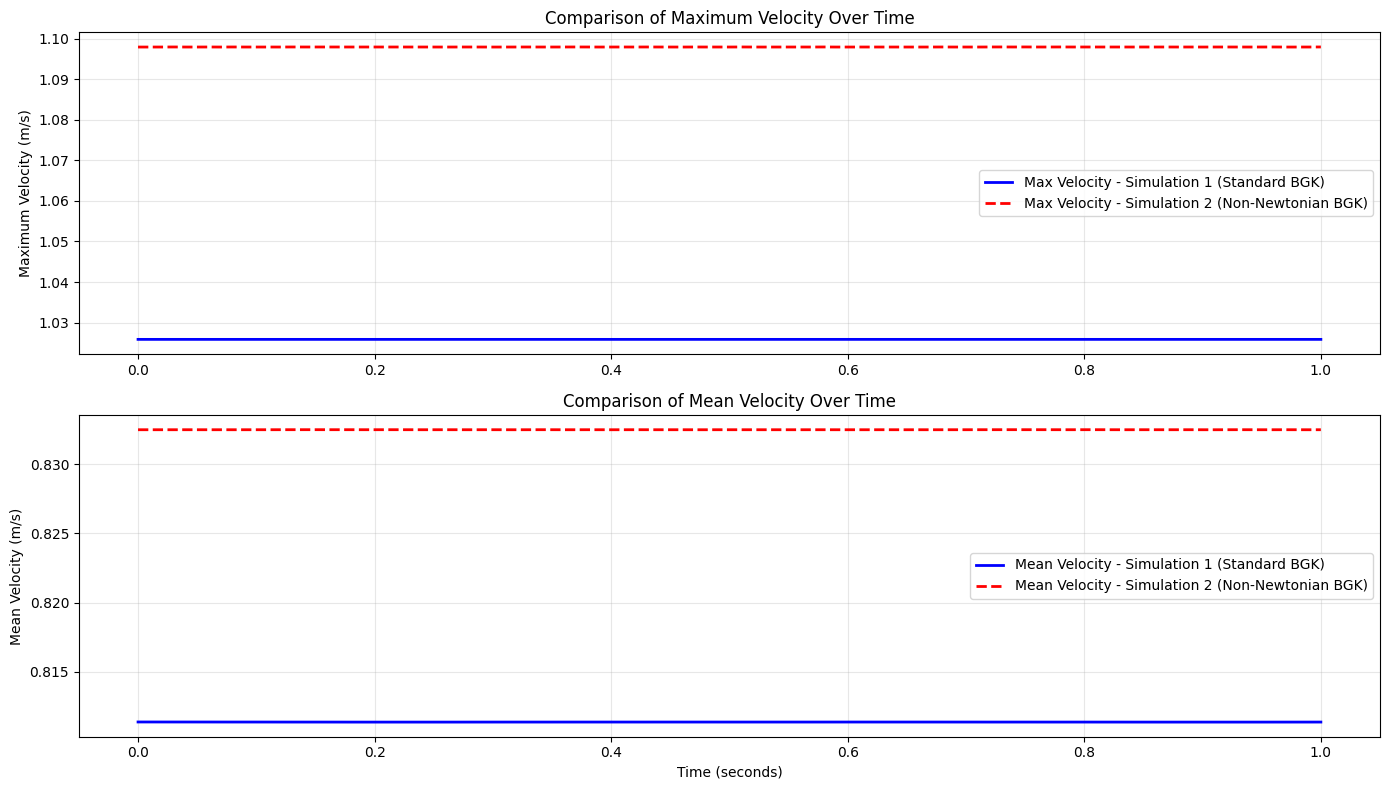

Velocity Difference Statistics (Sim2 - Sim1):
  Maximum Velocity: Mean diff = 7.02%, Max diff = 7.03%, Min diff = 7.02%
  Mean Velocity: Mean diff = 2.60%, Max diff = 2.60%, Min diff = 2.60%


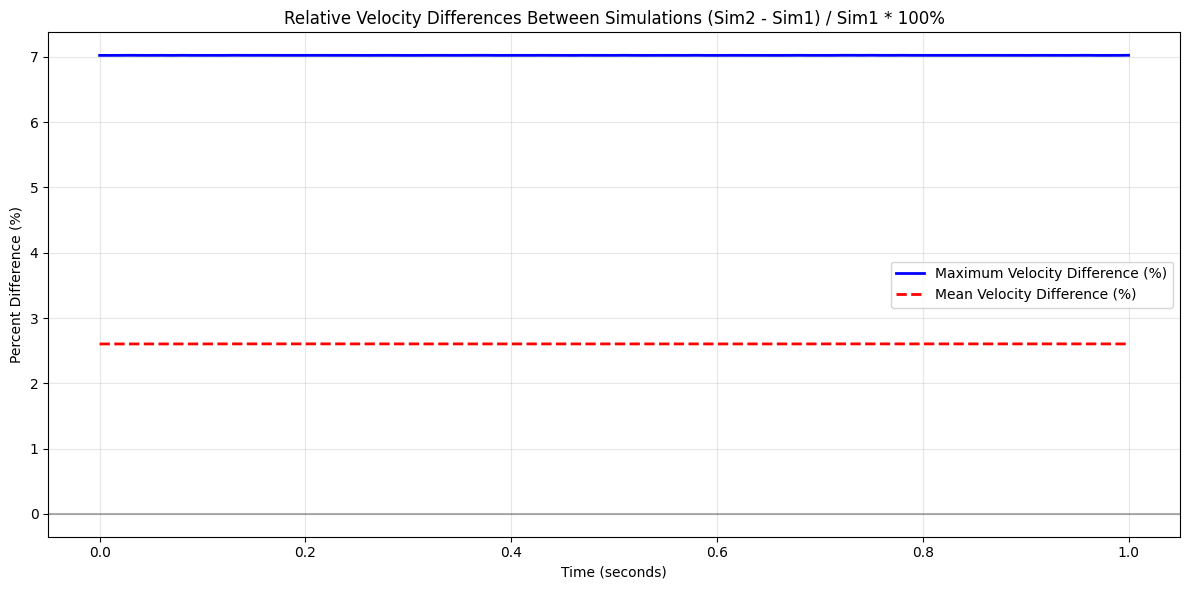

In [38]:
# Function to calculate mean and max velocity for each frame
def calculate_velocity_statistics(sim_data, dt, dx):
    """Calculate mean and maximum velocity for all frames in a simulation"""
    if 'u_magnitude' not in sim_data:
        return None, None, None
    
    u_magnitude_data = sim_data['u_magnitude']
    frame_numbers = sim_data['frame_numbers']
    n_frames = len(u_magnitude_data)
    
    # Arrays to store mean and max velocity for each frame
    mean_velocities = np.zeros(n_frames)
    max_velocities = np.zeros(n_frames)
    
    # Calculate statistics for each frame
    for i in range(n_frames):
        frame_data = u_magnitude_data[i]
        # Compute statistics only on non-zero elements (fluid domain)
        non_zero_mask = frame_data > 0
        if np.any(non_zero_mask):
            mean_velocities[i] = frame_data[non_zero_mask].mean()
            max_velocities[i] = frame_data.max()
        else:
            mean_velocities[i] = 0
            max_velocities[i] = 0
    
    # Calculate physical time for each frame
    physical_times = frame_numbers * dt
    
    # Convert velocities to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    mean_velocities_physical = mean_velocities * velocity_scale
    max_velocities_physical = max_velocities * velocity_scale
    
    return physical_times, mean_velocities_physical, max_velocities_physical

# Calculate statistics for both simulations
if sim1_loaded and sim2_loaded:
    # For simulation 1
    sim1_times, sim1_mean_vel, sim1_max_vel = calculate_velocity_statistics(sim1_data, dt1, dx1)
    
    # For simulation 2
    sim2_times, sim2_mean_vel, sim2_max_vel = calculate_velocity_statistics(sim2_data, dt2, dx2)
    
    # Create a figure comparing mean velocities
    plt.figure(figsize=(12, 6))
    plt.plot(sim1_times, sim1_mean_vel, 'b-', linewidth=2, label=f"Mean Velocity - {sim1_data['label']}")
    plt.plot(sim2_times, sim2_mean_vel, 'r--', linewidth=2, label=f"Mean Velocity - {sim2_data['label']}")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mean Velocity (m/s)')
    plt.title('Comparison of Mean Velocity Over Time')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Create a figure comparing maximum velocities
    plt.figure(figsize=(12, 6))
    plt.plot(sim1_times, sim1_max_vel, 'b-', linewidth=2, label=f"Max Velocity - {sim1_data['label']}")
    plt.plot(sim2_times, sim2_max_vel, 'r--', linewidth=2, label=f"Max Velocity - {sim2_data['label']}")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Maximum Velocity (m/s)')
    plt.title('Comparison of Maximum Velocity Over Time')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Create a combined figure with both mean and max velocity
    plt.figure(figsize=(14, 8))
    
    # Plot max velocities
    plt.subplot(2, 1, 1)
    plt.plot(sim1_times, sim1_max_vel, 'b-', linewidth=2, label=f"Max Velocity - {sim1_data['label']}")
    plt.plot(sim2_times, sim2_max_vel, 'r--', linewidth=2, label=f"Max Velocity - {sim2_data['label']}")
    plt.ylabel('Maximum Velocity (m/s)')
    plt.title('Comparison of Maximum Velocity Over Time')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot mean velocities
    plt.subplot(2, 1, 2)
    plt.plot(sim1_times, sim1_mean_vel, 'b-', linewidth=2, label=f"Mean Velocity - {sim1_data['label']}")
    plt.plot(sim2_times, sim2_mean_vel, 'r--', linewidth=2, label=f"Mean Velocity - {sim2_data['label']}")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mean Velocity (m/s)')
    plt.title('Comparison of Mean Velocity Over Time')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display velocity ratio differences
    max_vel_diff = (sim2_max_vel - sim1_max_vel) / sim1_max_vel * 100  # percent difference
    mean_vel_diff = (sim2_mean_vel - sim1_mean_vel) / sim1_mean_vel * 100  # percent difference
    
    print("Velocity Difference Statistics (Sim2 - Sim1):")
    print(f"  Maximum Velocity: Mean diff = {np.mean(max_vel_diff):.2f}%, Max diff = {np.max(max_vel_diff):.2f}%, Min diff = {np.min(max_vel_diff):.2f}%")
    print(f"  Mean Velocity: Mean diff = {np.mean(mean_vel_diff):.2f}%, Max diff = {np.max(mean_vel_diff):.2f}%, Min diff = {np.min(mean_vel_diff):.2f}%")
    
    # Plot the percent difference
    plt.figure(figsize=(12, 6))
    plt.plot(sim1_times, max_vel_diff, 'b-', linewidth=2, label='Maximum Velocity Difference (%)')
    plt.plot(sim1_times, mean_vel_diff, 'r--', linewidth=2, label='Mean Velocity Difference (%)')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Percent Difference (%)')
    plt.title('Relative Velocity Differences Between Simulations (Sim2 - Sim1) / Sim1 * 100%')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Compare Velocity Profiles at Specific Cross-Sections

Extract and compare velocity profiles at specific cross-sections of the simulation domain.


Comparing velocity profiles at frame 0 (t≈0.000s):


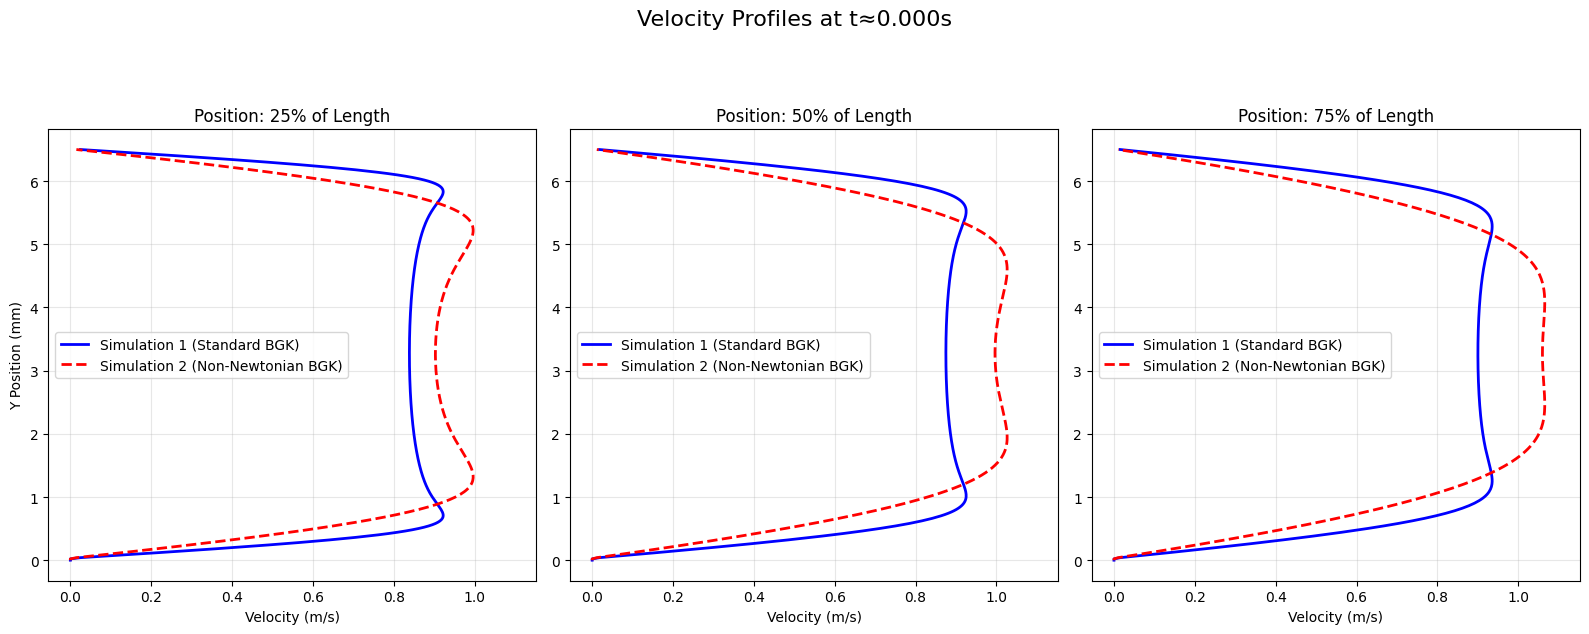


Comparing velocity profiles at frame 50 (t≈0.500s):


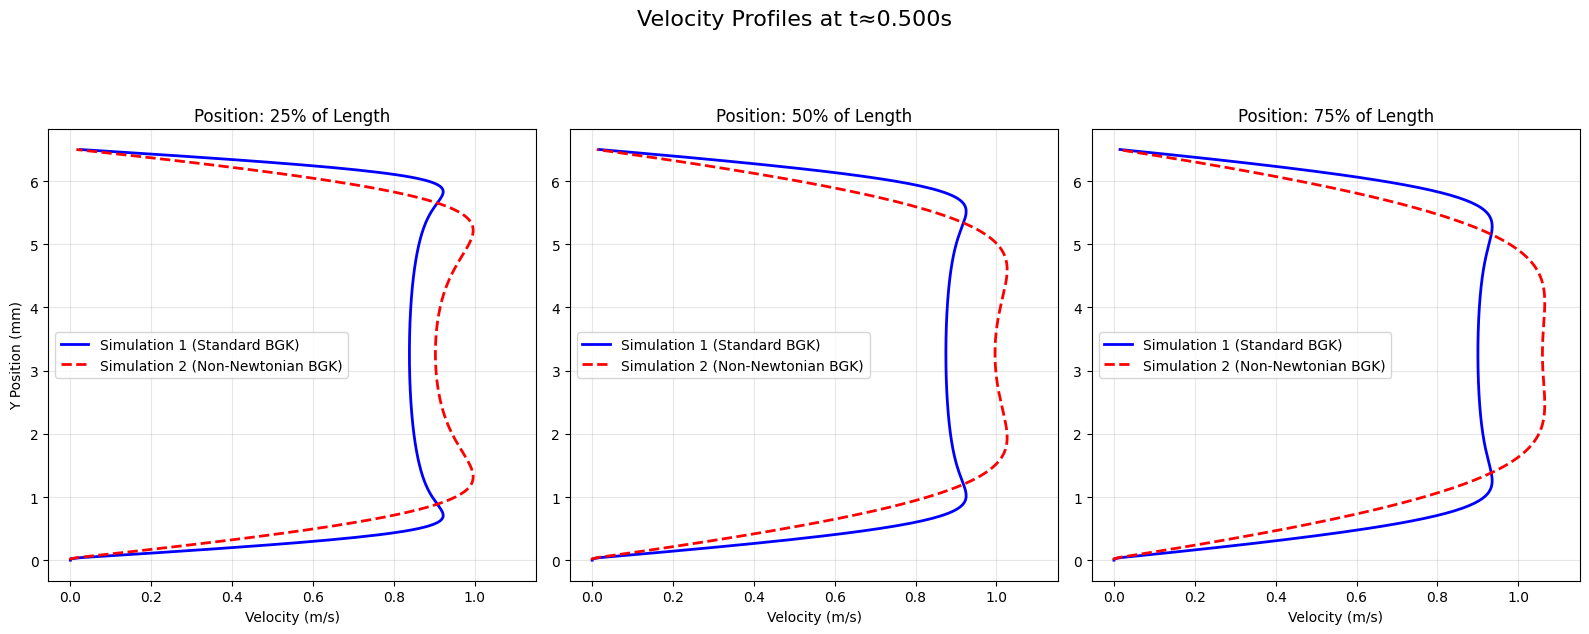


Comparing velocity profiles at frame 100 (t≈1.000s):


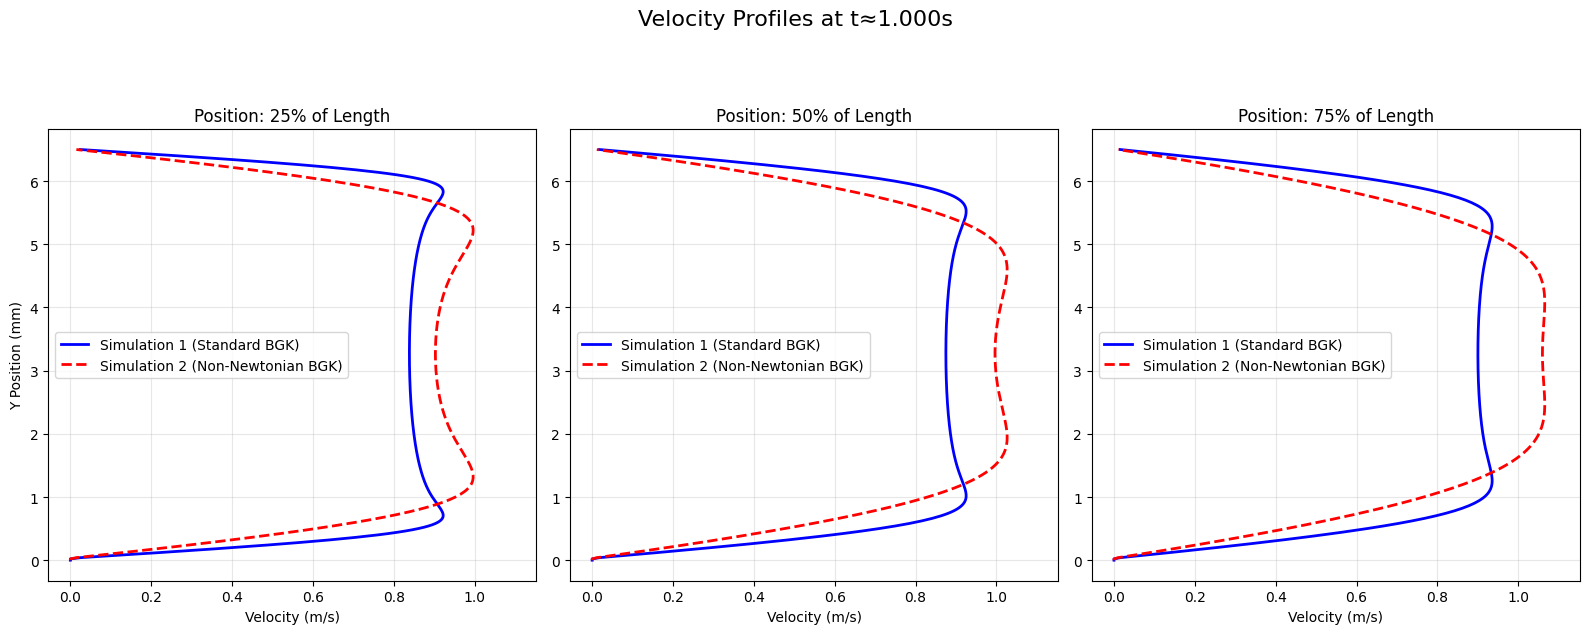

In [39]:
def compare_velocity_profiles(sim1_data, sim2_data, frame_idx=0, positions=None):
    """Compare velocity profiles at specific cross-sections between two simulations"""
    if not 'u_magnitude' in sim1_data or not 'u_magnitude' in sim2_data:
        print("Error: Velocity data not available for comparison")
        return
    
    # Get velocity data for the specified frame
    vel1 = sim1_data['u_magnitude'][frame_idx]
    vel2 = sim2_data['u_magnitude'][frame_idx]
    
    # Get the dimensions
    ny1, nx1 = vel1.shape
    ny2, nx2 = vel2.shape
    
    # If no positions specified, use default positions (25%, 50%, 75% along x-axis)
    if positions is None:
        positions = [0.25, 0.5, 0.75]
    
    # Create a figure for each position
    fig, axes = plt.subplots(1, len(positions), figsize=(16, 6))
    if len(positions) == 1:
        axes = [axes]  # Ensure axes is always a list
    
    # Convert velocities to physical units
    vel_scale1 = dx1 / dt1  # m/s per lattice unit
    vel_scale2 = dx2 / dt2  # m/s per lattice unit
    vel1_phys = vel1 * vel_scale1
    vel2_phys = vel2 * vel_scale2
    
    # Get physical time
    time1 = sim1_data['physical_times'][frame_idx]
    time2 = sim2_data['physical_times'][frame_idx]
    
    # Create y coordinate arrays in physical units (mm)
    y1_mm = np.linspace(0, ny1 * dx1 * 1000, ny1)  # Convert m to mm
    y2_mm = np.linspace(0, ny2 * dx2 * 1000, ny2)  # Convert m to mm
    
    # Interpolate sim2 data to match sim1 y-coordinates if they differ
    if np.any(y1_mm != y2_mm):
        from scipy.interpolate import interp1d
        print("Interpolating data to match y-coordinates...")
    
    # Plot velocity profiles at each position
    for i, pos in enumerate(positions):
        # Calculate x indices for this position
        x_idx1 = int(pos * nx1)
        x_idx2 = int(pos * nx2)
        
        # Get velocity profiles at this x position
        profile1 = vel1_phys[:, x_idx1]
        profile2 = vel2_phys[:, x_idx2]
        
        # Plot velocity profiles
        axes[i].plot(profile1, y1_mm, 'b-', linewidth=2, label=sim1_data['label'])
        axes[i].plot(profile2, y2_mm, 'r--', linewidth=2, label=sim2_data['label'])
        
        # Customize the plot
        axes[i].set_title(f"Position: {pos*100:.0f}% of Length")
        axes[i].set_xlabel('Velocity (m/s)')
        if i == 0:
            axes[i].set_ylabel('Y Position (mm)')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    # Set the same velocity range for all plots
    all_profiles = np.concatenate([vel1_phys.flatten(), vel2_phys.flatten()])
    v_min, v_max = all_profiles.min(), all_profiles.max()
    v_range = v_max - v_min
    for ax in axes:
        ax.set_xlim(v_min - 0.05*v_range, v_max + 0.05*v_range)
    
    plt.suptitle(f"Velocity Profiles at t≈{time1:.3f}s", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Compare velocity profiles at specific time points if data is available
if sim1_loaded and sim2_loaded:
    # Choose frames at specific time points
    # For example, at peak velocity, middle of cycle, and end of cycle
    peak_idx = np.argmax(sim1_mean_vel)
    middle_idx = len(sim1_data['frame_numbers']) // 2
    end_idx = len(sim1_data['frame_numbers']) - 1
    
    frames_to_analyze = [peak_idx, middle_idx, end_idx]
    positions = [0.25, 0.5, 0.75]  # 25%, 50%, and 75% along the pipe length
    
    for idx in frames_to_analyze:
        print(f"\nComparing velocity profiles at frame {idx} (t≈{sim1_data['physical_times'][idx]:.3f}s):")
        compare_velocity_profiles(sim1_data, sim2_data, frame_idx=idx, positions=positions)

## Difference Visualization

Create visualizations that directly show the differences between the two simulations.


Visualizing velocity differences at peak velocity (frame 0, t≈0.000s):


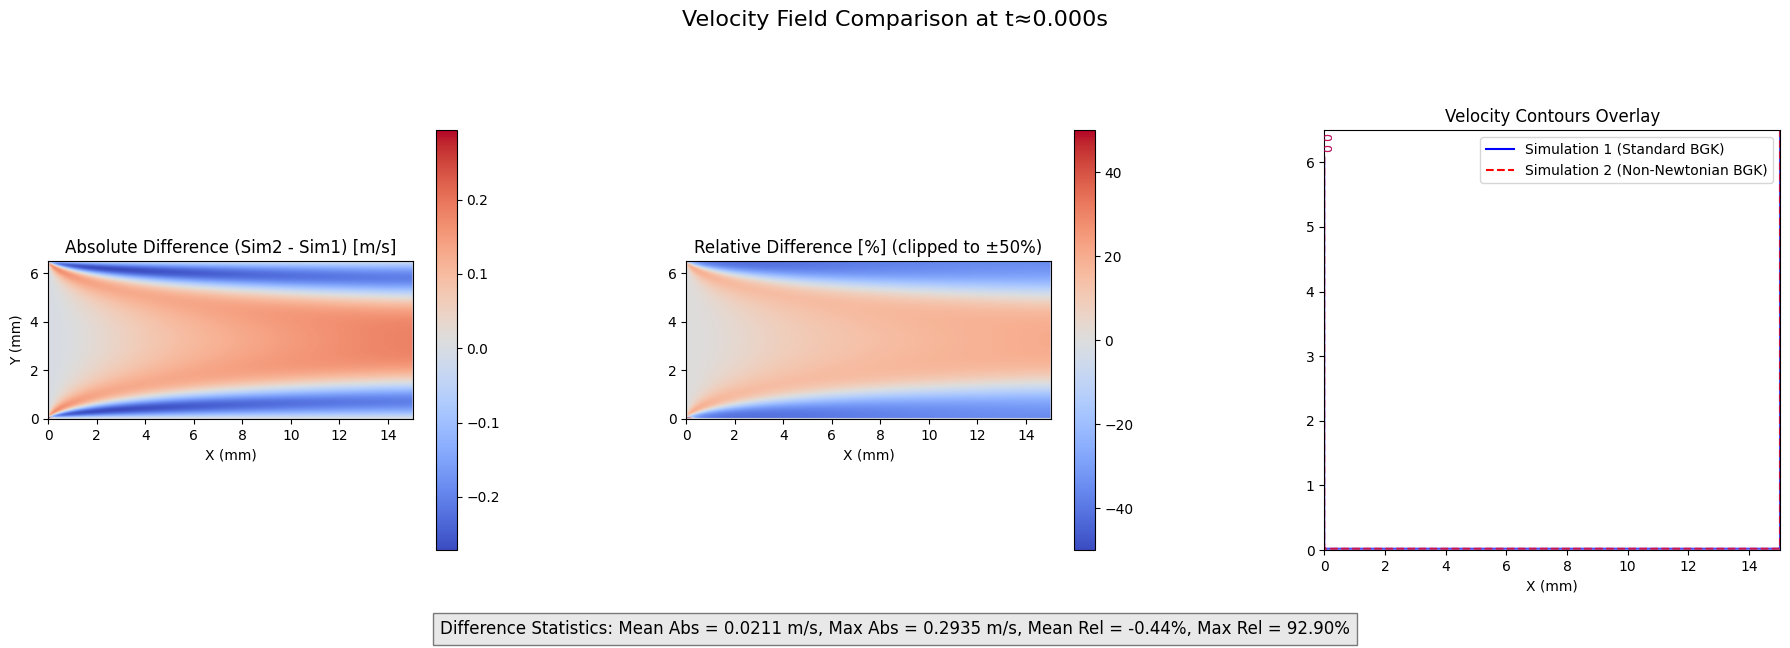

In [40]:
def visualize_velocity_differences(sim1_data, sim2_data, frame_idx=0):
    """Visualize the differences between velocity fields from two simulations"""
    if not 'u_magnitude' in sim1_data or not 'u_magnitude' in sim2_data:
        print("Error: Velocity data not available for comparison")
        return
    
    # Get velocity data for the specified frame
    vel1 = sim1_data['u_magnitude'][frame_idx]
    vel2 = sim2_data['u_magnitude'][frame_idx]
    
    # Get dimensions
    ny1, nx1 = vel1.shape
    ny2, nx2 = vel2.shape
    
    # Convert to physical units
    vel_scale1 = dx1 / dt1  # m/s per lattice unit
    vel_scale2 = dx2 / dt2  # m/s per lattice unit
    vel1_phys = vel1 * vel_scale1
    vel2_phys = vel2 * vel_scale2
    
    # Create coordinate grids in physical units (mm)
    x1_mm = np.linspace(0, nx1 * dx1 * 1000, nx1)  # Convert m to mm
    y1_mm = np.linspace(0, ny1 * dx1 * 1000, ny1)  # Convert m to mm
    x2_mm = np.linspace(0, nx2 * dx2 * 1000, nx2)  # Convert m to mm
    y2_mm = np.linspace(0, ny2 * dx2 * 1000, ny2)  # Convert m to mm
    
    # We need to ensure the velocity fields are on the same grid for comparison
    # If the dimensions differ, we need to interpolate
    from scipy.interpolate import RegularGridInterpolator
    
    # Create interpolator for the second velocity field
    interp_func = RegularGridInterpolator((y2_mm, x2_mm), vel2_phys, 'linear', False)
    
    # Create meshgrid for interpolation
    Y1, X1 = np.meshgrid(y1_mm, x1_mm, indexing='ij')
    points = np.column_stack((Y1.flatten(), X1.flatten()))
    
    # Interpolate the second velocity field onto the first grid
    vel2_interp = interp_func(points).reshape(ny1, nx1)
    
    # Calculate absolute and relative differences
    abs_diff = vel2_interp - vel1_phys
    rel_diff = np.zeros_like(abs_diff)
    non_zero = vel1_phys > 1e-10  # Avoid division by near-zero
    rel_diff[non_zero] = (abs_diff[non_zero] / vel1_phys[non_zero]) * 100  # percent
    
    # Create figure for comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Absolute difference plot
    im1 = axes[0].imshow(abs_diff, cmap='coolwarm', origin='lower',
                        extent=[0, max(x1_mm), 0, max(y1_mm)])
    axes[0].set_title('Absolute Difference (Sim2 - Sim1) [m/s]')
    axes[0].set_xlabel('X (mm)')
    axes[0].set_ylabel('Y (mm)')
    fig.colorbar(im1, ax=axes[0])
    
    # Relative difference plot (percentage)
    # Clip extreme values for better visualization
    rel_diff_clipped = np.clip(rel_diff, -50, 50)
    im2 = axes[1].imshow(rel_diff_clipped, cmap='coolwarm', origin='lower',
                        vmin=-50, vmax=50,
                        extent=[0, max(x1_mm), 0, max(y1_mm)])
    axes[1].set_title('Relative Difference [%] (clipped to ±50%)')
    axes[1].set_xlabel('X (mm)')
    fig.colorbar(im2, ax=axes[1])
    
    # Overlay of both fields
    # Compute a common colormap range
    vmin = min(vel1_phys.min(), vel2_interp.min())
    vmax = max(vel1_phys.max(), vel2_interp.max())
    
    # Reduce the number of contour levels to prevent overcrowding
    # Using just 1 contour level for maximum clarity and simplicity
    levels = np.linspace(vmin, vmax, 1)
    
    # Create contour plots with a single level and increased linewidth for better visibility
    cs1 = axes[2].contour(X1[0,:], Y1[:,0], vel1_phys, levels=levels, colors='blue', linestyles='-', alpha=0.7, linewidths=1.5)
    cs2 = axes[2].contour(X1[0,:], Y1[:,0], vel2_interp, levels=levels, colors='red', linestyles='--', alpha=0.7, linewidths=1.5)
    
    # Add labels to the contours with slightly larger font for readability
    # Format with fewer decimal places to reduce clutter
    axes[2].clabel(cs1, inline=1, fontsize=9, fmt='%.1f')
    axes[2].clabel(cs2, inline=1, fontsize=9, fmt='%.1f')
    
    # Add a legend
    axes[2].plot([], [], 'b-', linewidth=1.5, label=sim1_data['label'])
    axes[2].plot([], [], 'r--', linewidth=1.5, label=sim2_data['label'])
    axes[2].legend()
    
    axes[2].set_title('Velocity Contours Overlay')
    axes[2].set_xlabel('X (mm)')
    
    # Get time information
    time1 = sim1_data['physical_times'][frame_idx]
    time2 = sim2_data['physical_times'][frame_idx]
    
    # Add statistics to figure
    non_zero_mask = ~np.isclose(vel1_phys, 0) & ~np.isclose(vel2_interp, 0)
    rel_diff_valid = rel_diff[non_zero_mask]
    
    abs_diff_mean = np.mean(abs_diff[non_zero_mask])
    abs_diff_max = np.max(np.abs(abs_diff[non_zero_mask]))
    rel_diff_mean = np.mean(rel_diff_valid)
    rel_diff_max = np.max(np.abs(rel_diff_valid))
    
    plt.figtext(0.5, 0.01, 
                f"Difference Statistics: Mean Abs = {abs_diff_mean:.4f} m/s, Max Abs = {abs_diff_max:.4f} m/s, "
                f"Mean Rel = {rel_diff_mean:.2f}%, Max Rel = {rel_diff_max:.2f}%",
                ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
    
    plt.suptitle(f"Velocity Field Comparison at t≈{time1:.3f}s", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4, top=0.85, bottom=0.15)
    plt.show()
    
    return abs_diff, rel_diff

# Visualize differences at peak velocity frame
if sim1_loaded and sim2_loaded:
    peak_idx = np.argmax(sim1_mean_vel)
    print(f"\nVisualizing velocity differences at peak velocity (frame {peak_idx}, t≈{sim1_data['physical_times'][peak_idx]:.3f}s):")
    abs_diff, rel_diff = visualize_velocity_differences(sim1_data, sim2_data, frame_idx=peak_idx)

## Summary and Conclusions

Summarize the key findings from the comparative analysis.

In [41]:
# Create a summary of the comparative analysis
if sim1_loaded and sim2_loaded:
    print("\n" + "="*80)
    print("SIMULATION COMPARISON SUMMARY")
    print("="*80)
    
    # Calculate overall statistics
    max_vel_diff_mean = np.mean(max_vel_diff)
    max_vel_diff_std = np.std(max_vel_diff)
    mean_vel_diff_mean = np.mean(mean_vel_diff)
    mean_vel_diff_std = np.std(mean_vel_diff)
    
    print("\nKey Velocity Differences:")
    print(f"  Mean Velocity: {mean_vel_diff_mean:.2f}% ± {mean_vel_diff_std:.2f}% (Sim2 relative to Sim1)")
    print(f"  Maximum Velocity: {max_vel_diff_mean:.2f}% ± {max_vel_diff_std:.2f}% (Sim2 relative to Sim1)")
    
    # Identify where the largest differences occur
    max_diff_time_idx = np.argmax(np.abs(max_vel_diff))
    max_diff_time = sim1_times[max_diff_time_idx]
    max_diff_value = max_vel_diff[max_diff_time_idx]
    
    print(f"\nMaximum difference of {max_diff_value:.2f}% occurs at t = {max_diff_time:.3f}s")
    
    # Highlight meaningful differences between models
    print("\nComparison Conclusions:")
    
    # Check if there's a consistent pattern to the velocity differences
    if np.mean(max_vel_diff) > 5:
        print(f"  - {sim2_data['label']} consistently shows higher maximum velocities than {sim1_data['label']}")
    elif np.mean(max_vel_diff) < -5:
        print(f"  - {sim2_data['label']} consistently shows lower maximum velocities than {sim1_data['label']}")
    else:
        print(f"  - Maximum velocities are similar between the two models (within ±5%)")
        
    if np.mean(mean_vel_diff) > 5:
        print(f"  - {sim2_data['label']} consistently shows higher mean velocities than {sim1_data['label']}")
    elif np.mean(mean_vel_diff) < -5:
        print(f"  - {sim2_data['label']} consistently shows lower mean velocities than {sim1_data['label']}")
    else:
        print(f"  - Mean velocities are similar between the two models (within ±5%)")
        
    # Check if the differences are time-dependent
    max_vel_diff_range = np.max(max_vel_diff) - np.min(max_vel_diff)
    if max_vel_diff_range > 10:
        print(f"  - Velocity differences vary significantly over time (range: {max_vel_diff_range:.1f}%)")
        print(f"    This suggests the models respond differently to the time-varying flow conditions")
    else:
        print(f"  - Velocity differences are relatively consistent over time")
        
    # Possible rheological effects
    if 'Rheology Model' in sim1_params and 'Rheology Model' in sim2_params:
        if sim1_params['Rheology Model'] != sim2_params['Rheology Model']:
            print(f"\nRheological Model Comparison:")
            print(f"  - {sim1_data['label']}: {sim1_params['Rheology Model']}")
            print(f"  - {sim2_data['label']}: {sim2_params['Rheology Model']}")
            
            if np.abs(np.mean(max_vel_diff)) > 5:
                print(f"  - The difference in rheological models appears to significantly affect the flow behavior")
                if 'Non-Newtonian' in sim2_params['Rheology Model']:
                    print(f"  - The Non-Newtonian model shows {'higher' if np.mean(max_vel_diff) > 0 else 'lower'} velocities")
            else:
                print(f"  - Despite the different rheological models, the overall flow behavior is similar")
    
    print("\nThis comparative analysis helps identify the impact of different modeling approaches on flow predictions.")
    print("Further detailed analysis is needed to connect these differences to clinical implications.")
    print("="*80)


SIMULATION COMPARISON SUMMARY

Key Velocity Differences:
  Mean Velocity: 2.60% ± 0.00% (Sim2 relative to Sim1)
  Maximum Velocity: 7.02% ± 0.00% (Sim2 relative to Sim1)

Maximum difference of 7.03% occurs at t = 0.750s

Comparison Conclusions:
  - Simulation 2 (Non-Newtonian BGK) consistently shows higher maximum velocities than Simulation 1 (Standard BGK)
  - Mean velocities are similar between the two models (within ±5%)
  - Velocity differences are relatively consistent over time

Rheological Model Comparison:
  - Simulation 1 (Standard BGK): Newtonian
  - Simulation 2 (Non-Newtonian BGK): Carreau-Yasuda
  - The difference in rheological models appears to significantly affect the flow behavior

This comparative analysis helps identify the impact of different modeling approaches on flow predictions.
Further detailed analysis is needed to connect these differences to clinical implications.


## Velocity Contours Overlay Explanation

The velocity contours overlay in the third subplot provides a direct visual comparison of flow patterns between simulations:

1. **Contour Lines**: Each line represents locations of equal velocity magnitude
   - Blue solid line: Simulation 1 (Standard BGK)
   - Red dashed line: Simulation 2 (Non-Newtonian BGK)

2. **Interpretation**:
   - Where contour lines overlap closely: the models predict similar velocities
   - Where contour lines diverge: model predictions differ significantly
   - The single contour line represents the median velocity value

3. **Technical Implementation**:
   - Uses a single contour level for maximum clarity and minimal overlap
   - Numerical labels show velocity values in m/s
   - Simulation 2 data is interpolated onto Simulation 1's grid for direct comparison